In [1]:
import numpy as np
from pathlib import Path
import tensorflow as tf
from keras.layers import Input, RandomFlip, RandomContrast, BatchNormalization, RandomTranslation, Flatten, Dropout
from keras.layers import Dense, Conv2D, Activation, MaxPooling2D, GlobalMaxPooling2D, Rescaling
import matplotlib.pyplot as plt
from PIL import Image
import os

In [2]:
dir_act = os.getcwd()
str(Path(f'{dir_act}/seg_train'))
str(Path(f'{dir_act}/seg_train'))

'c:\\Users\\Usuario\\Documents\\AA2-TUIA-TP1\\problema_3\\seg_train'

In [7]:
# Directorio de los datos
dir_act = os.getcwd()
DATA_TRAIN_DIRECTORY = str(Path(dir_act,'seg_train'))
DATA_VAL_DIRECTORY = str(Path(dir_act,'seg_test'))
DATA_TEST_DIRECTORY = str(Path(dir_act,'seg_pred'))
# Tamaño del lote (batch size)
BATCH_SIZE = 64
# Tamaño de las imágenes
IMAGE_HEIGHT = 150
IMAGE_WIDTH = 150

# Carga los datos de entrenamiento y validación
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_TRAIN_DIRECTORY,
    label_mode="categorical",
    seed=123,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)
val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_VAL_DIRECTORY,
    label_mode="categorical",
    seed=123,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)
test_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_TEST_DIRECTORY,
    label_mode=None,
    seed=123,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.
Found 7301 files.


In [18]:
# Obtiene los nombres de las clases
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


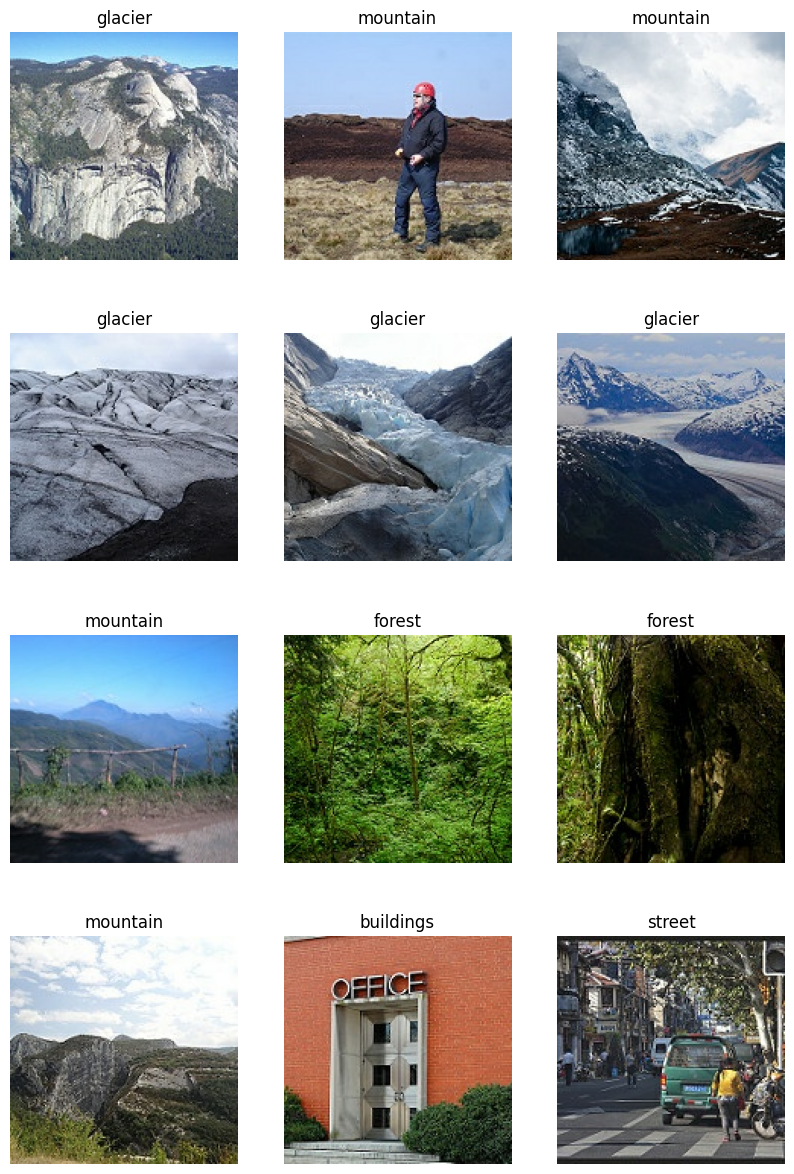

In [5]:
# Muestra algunas imágenes de ejemplo
plt.figure(figsize=(10, 15))
for images, labels in train_ds.take(1):
  for i in range(12):
    ax = plt.subplot(4, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    class_idx = list(labels[i]).index(1)
    plt.title(class_names[class_idx])
    plt.axis("off")

In [17]:
def graficar_desempeño_modelo(history):
    # Plot the training history, accuracy and loss
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='entrenamiento')
    plt.plot(history.history['val_accuracy'], label = 'validación')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='entrenamiento')
    plt.plot(history.history['val_loss'], label = 'validación')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([0, 2])
    plt.legend(loc='upper right')
    plt.suptitle('Evolución del accuracy y de la pérdida en entrenamiento y validación en función a las épocas')
    plt.tight_layout()
    plt.show()

In [ ]:
def gurdar_modelo(modelo,nombre):
    modelo.save(f'./{nombre}.keras')

In [21]:
def graficar_prediccion_modelo(modelo):
    # Test images directory
    TEST_IMAGES_DIRECTORY = Path("seg_pred")

    # Get list of test image paths
    test_image_paths = list(TEST_IMAGES_DIRECTORY.glob("*.jpg"))
    print(test_image_paths)
    # Display 5 images with their actual and predicted classes
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))

    for i, ax in enumerate(axes):
        # Preprocess the image
        image_path = test_image_paths[i]
        image = Image.open(image_path)
        ax.imshow(image)
        ax.axis('off')

        image = np.expand_dims(image, axis=0)  # Add batch dimension

        # Perform prediction
        prediction = modelo.predict(image)
        predicted_class_index = np.argmax(prediction)
        predicted_class = class_names[predicted_class_index]

        # Display result
        ax.set_title(f"Predicted: {predicted_class}")

    plt.tight_layout()
    plt.show()

# Modelo con capas densan

In [18]:
# Función para construir el modelo
def build_model_densas(input_shape, output_labels):
    i = Input(input_shape, dtype=tf.float32)

    x = Rescaling(1./255)(i)
    x = RandomFlip("horizontal")(x)
    x = RandomFlip("vertical")(x)
    x = RandomTranslation(0.1, 0.1, fill_mode="reflect")(x)
    x = RandomContrast(0.2)(x)

    x = Flatten()(x)

    x = Dense(64)(x)
    x = Activation("relu")(x)
    x = Dense(32)(x)
    x = Activation("relu")(x)
    x = Dense(output_labels)(x)
    x = Activation("softmax")(x)
    return tf.keras.Model(inputs=[i], outputs=[x])

In [19]:
print("Building model")
model_densas = build_model_densas((IMAGE_HEIGHT, IMAGE_WIDTH, 3), num_classes)

model_densas.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=['accuracy'])

Building model


In [20]:
model_densas.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_4 (RandomFlip)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_5 (RandomFlip)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_translation_2            │ (None, 150, 150, 3)    │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast_2               │ (None, 150, 150, 3)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 67500)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │     4,320,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │           198 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 6)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,322,342 (16.49 MB)

 Trainable params: 4,322,342 (16.49 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# # Número de épocas de entrenamiento
# EPOCHS = 60
# # Entrena el modelo
# history_densas = model_densas.fit(
#     train_ds,
#     validation_data=val_ds,
#     epochs=EPOCHS,
#     batch_size=BATCH_SIZE
# )

Epoch 1/60


C:\Users\Usuario\AppData\Roaming\Python\Python311\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_42']
Received: inputs=Tensor(shape=(None, 150, 150, 3))
  warnings.warn(msg)


220/220 ━━━━━━━━━━━━━━━━━━━━ 21s 93ms/step - accuracy: 0.2593 - loss: 4.7661 - val_accuracy: 0.4617 - val_loss: 1.4248
Epoch 2/60
220/220 ━━━━━━━━━━━━━━━━━━━━ 24s 108ms/step - accuracy: 0.4342 - loss: 1.4856 - val_accuracy: 0.4387 - val_loss: 1.4384
Epoch 3/60
220/220 ━━━━━━━━━━━━━━━━━━━━ 24s 107ms/step - accuracy: 0.4448 - loss: 1.4585 - val_accuracy: 0.4480 - val_loss: 1.4483
Epoch 4/60
220/220 ━━━━━━━━━━━━━━━━━━━━ 25s 111ms/step - accuracy: 0.4674 - loss: 1.3957 - val_accuracy: 0.4750 - val_loss: 1.3808
Epoch 5/60
220/220 ━━━━━━━━━━━━━━━━━━━━ 24s 108ms/step - accuracy: 0.4558 - loss: 1.3910 - val_accuracy: 0.5000 - val_loss: 1.3256
Epoch 6/60
220/220 ━━━━━━━━━━━━━━━━━━━━ 22s 99ms/step - accuracy: 0.4692 - loss: 1.3588 - val_accuracy: 0.4853 - val_loss: 1.3968
Epoch 7/60
220/220 ━━━━━━━━━━━━━━━━━━━━ 22s 98ms/step - accuracy: 0.4879 - loss: 1.3335 - val_accuracy: 0.4137 - val_loss: 1.4239
Epoch 8/60
220/220 ━━━━━━━━━━━━━━━━━━━━ 21s 94ms/step - accuracy: 0.4730 - loss: 1.3513 - val_acc

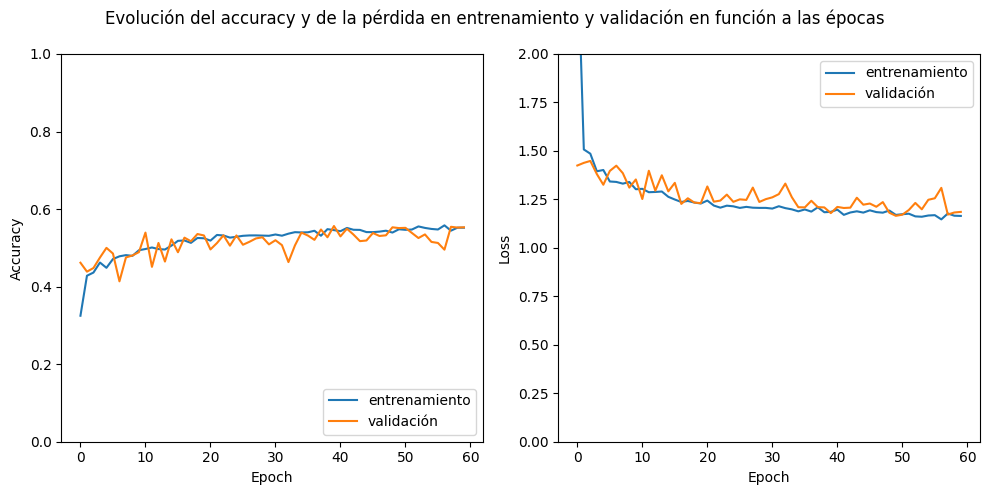

In [ ]:
# graficar_desempeño_modelo(history=history_densas)

In [ ]:
# gurdar_modelo(modelo=model_densas,nombre='model_densas')

[WindowsPath('seg_pred/10004.jpg'), WindowsPath('seg_pred/10005.jpg'), WindowsPath('seg_pred/10012.jpg'), WindowsPath('seg_pred/10013.jpg'), WindowsPath('seg_pred/10017.jpg'), WindowsPath('seg_pred/10021.jpg'), WindowsPath('seg_pred/1003.jpg'), WindowsPath('seg_pred/10034.jpg'), WindowsPath('seg_pred/10038.jpg'), WindowsPath('seg_pred/10040.jpg'), WindowsPath('seg_pred/10043.jpg'), WindowsPath('seg_pred/10045.jpg'), WindowsPath('seg_pred/10047.jpg'), WindowsPath('seg_pred/10048.jpg'), WindowsPath('seg_pred/10052.jpg'), WindowsPath('seg_pred/10054.jpg'), WindowsPath('seg_pred/10059.jpg'), WindowsPath('seg_pred/10060.jpg'), WindowsPath('seg_pred/10066.jpg'), WindowsPath('seg_pred/10069.jpg'), WindowsPath('seg_pred/10073.jpg'), WindowsPath('seg_pred/10079.jpg'), WindowsPath('seg_pred/1008.jpg'), WindowsPath('seg_pred/10082.jpg'), WindowsPath('seg_pred/10083.jpg'), WindowsPath('seg_pred/10090.jpg'), WindowsPath('seg_pred/10092.jpg'), WindowsPath('seg_pred/10096.jpg'), WindowsPath('seg_pred

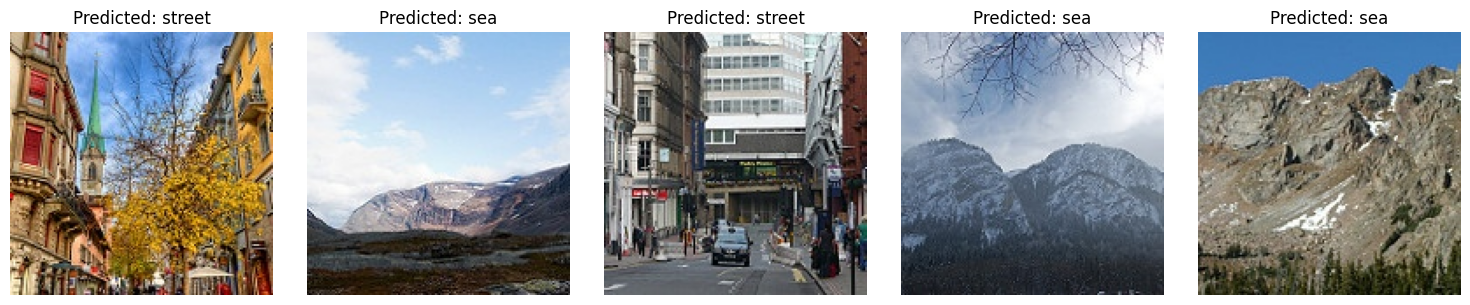

In [25]:
model_densas = tf.keras.models.load_model('model_densas.keras')
graficar_prediccion_modelo(model_densas)

# Modelo con capas convolucionales y densas

In [28]:
# Función para construir el modelo
def build_model_cnn(input_shape, output_labels):
    i = Input(input_shape, dtype=tf.float32)

    x = Rescaling(1./255)(i)
    x = RandomFlip("horizontal")(x)
    x = RandomFlip("vertical")(x)
    x = RandomTranslation(0.1, 0.1, fill_mode="reflect")(x)
    x = RandomContrast(0.2)(x)

    x = Conv2D(16, (3, 3))(x)
    x = Activation("relu")(x)

    x = Conv2D(32, (3, 3))(x)
    x = Activation("relu")(x)

    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3))(x)
    x = Activation("relu")(x)

    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3))(x)
    x = Activation("relu")(x)

    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    x = Dropout(0.2)(x)
    x = Dense(output_labels)(x)
    x = Activation("softmax")(x)
    return tf.keras.Model(inputs=[i], outputs=[x])

In [ ]:
print("Building model")
model_cnn = build_model_cnn((IMAGE_HEIGHT, IMAGE_WIDTH, 3), num_classes)

model_cnn.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=['accuracy'])

Building model


In [ ]:
model_cnn.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_4 (Rescaling)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_8 (RandomFlip)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_9 (RandomFlip)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_translation_4            │ (None, 150, 150, 3)    │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast_4               │ (None, 150, 150, 3)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 148, 148, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_18 (Activation)      │ (None, 148, 148, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 146, 146, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_19 (Activation)      │ (None, 146, 146, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 73, 73, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 71, 71, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_20 (Activation)      │ (None, 71, 71, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 35, 35, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 33, 33, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_21 (Activation)      │ (None, 33, 33, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 6)              │        98,310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_22 (Activation)      │ (None, 6)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 158,822 (620.40 KB)

 Trainable params: 158,822 (620.40 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# # Número de épocas de entrenamiento
# EPOCHS = 60
# # Entrena el modelo
# history = model_cnn.fit(
#     train_ds,
#     validation_data=val_ds,
#     epochs=EPOCHS,
#     batch_size=BATCH_SIZE
# )

Epoch 1/60


C:\Users\Usuario\AppData\Roaming\Python\Python311\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_76']
Received: inputs=Tensor(shape=(None, 150, 150, 3))
  warnings.warn(msg)


220/220 ━━━━━━━━━━━━━━━━━━━━ 123s 549ms/step - accuracy: 0.4616 - loss: 1.2910 - val_accuracy: 0.6677 - val_loss: 0.8825
Epoch 2/60
220/220 ━━━━━━━━━━━━━━━━━━━━ 113s 514ms/step - accuracy: 0.6603 - loss: 0.8880 - val_accuracy: 0.6747 - val_loss: 0.8517
Epoch 3/60
220/220 ━━━━━━━━━━━━━━━━━━━━ 114s 519ms/step - accuracy: 0.7105 - loss: 0.7752 - val_accuracy: 0.7603 - val_loss: 0.6655
Epoch 4/60
220/220 ━━━━━━━━━━━━━━━━━━━━ 116s 527ms/step - accuracy: 0.7323 - loss: 0.7074 - val_accuracy: 0.7397 - val_loss: 0.6758
Epoch 5/60
220/220 ━━━━━━━━━━━━━━━━━━━━ 116s 527ms/step - accuracy: 0.7612 - loss: 0.6509 - val_accuracy: 0.7703 - val_loss: 0.6124
Epoch 6/60
220/220 ━━━━━━━━━━━━━━━━━━━━ 114s 516ms/step - accuracy: 0.7789 - loss: 0.6106 - val_accuracy: 0.7997 - val_loss: 0.5505
Epoch 7/60
220/220 ━━━━━━━━━━━━━━━━━━━━ 130s 592ms/step - accuracy: 0.7834 - loss: 0.5972 - val_accuracy: 0.7963 - val_loss: 0.5541
Epoch 8/60
220/220 ━━━━━━━━━━━━━━━━━━━━ 123s 558ms/step - accuracy: 0.7981 - loss: 0.54

In [ ]:
# gurdar_modelo(modelo=model_cnn,nombre='model_cnn')

[WindowsPath('seg_pred/10004.jpg'), WindowsPath('seg_pred/10005.jpg'), WindowsPath('seg_pred/10012.jpg'), WindowsPath('seg_pred/10013.jpg'), WindowsPath('seg_pred/10017.jpg'), WindowsPath('seg_pred/10021.jpg'), WindowsPath('seg_pred/1003.jpg'), WindowsPath('seg_pred/10034.jpg'), WindowsPath('seg_pred/10038.jpg'), WindowsPath('seg_pred/10040.jpg'), WindowsPath('seg_pred/10043.jpg'), WindowsPath('seg_pred/10045.jpg'), WindowsPath('seg_pred/10047.jpg'), WindowsPath('seg_pred/10048.jpg'), WindowsPath('seg_pred/10052.jpg'), WindowsPath('seg_pred/10054.jpg'), WindowsPath('seg_pred/10059.jpg'), WindowsPath('seg_pred/10060.jpg'), WindowsPath('seg_pred/10066.jpg'), WindowsPath('seg_pred/10069.jpg'), WindowsPath('seg_pred/10073.jpg'), WindowsPath('seg_pred/10079.jpg'), WindowsPath('seg_pred/1008.jpg'), WindowsPath('seg_pred/10082.jpg'), WindowsPath('seg_pred/10083.jpg'), WindowsPath('seg_pred/10090.jpg'), WindowsPath('seg_pred/10092.jpg'), WindowsPath('seg_pred/10096.jpg'), WindowsPath('seg_pred

C:\Users\Usuario\AppData\Roaming\Python\Python311\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


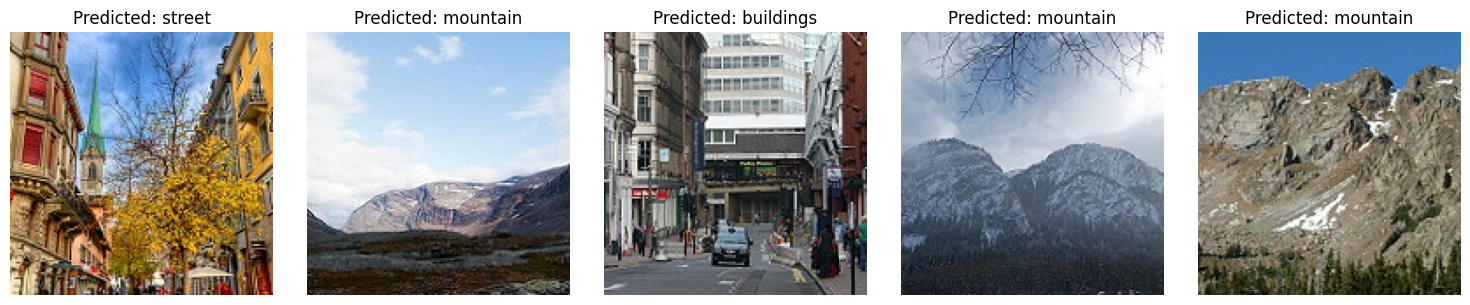

In [26]:
model_cnn = tf.keras.models.load_model('model_cnn.keras')
graficar_prediccion_modelo(model_cnn)

# Modelo con transfer learning

In [32]:
def build_model_tl(input_shape, num_classes):
    base_model = tf.keras.applications.EfficientNetB0(input_shape=input_shape,
                                                include_top=False,
                                                weights='imagenet')
    base_model.trainable = False

    i = Input(shape=input_shape)
    x = base_model(i, training=False)
    x = GlobalMaxPooling2D()(x)
    x = Dense(num_classes, activation='softmax')(x)

    return tf.keras.Model(i, x)

In [33]:
print("Building model")
model_tl = build_model_tl((IMAGE_HEIGHT, IMAGE_WIDTH, 3), num_classes)

model_tl.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=['accuracy'])

Building model
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 14s 1us/step


In [34]:
model_tl.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 5, 5, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 1280)           │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │         7,686 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,057,257 (15.48 MB)

 Trainable params: 7,686 (30.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
# # Número de épocas de entrenamiento
# EPOCHS = 30
# # Entrena el modelo
# history_tl = model_tl.fit(
#     train_ds,
#     validation_data=val_ds,
#     epochs=EPOCHS,
#     batch_size=BATCH_SIZE
# )

Epoch 1/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 154s 657ms/step - accuracy: 0.7143 - loss: 0.9848 - val_accuracy: 0.8833 - val_loss: 0.3407
Epoch 2/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 131s 597ms/step - accuracy: 0.8858 - loss: 0.3236 - val_accuracy: 0.8993 - val_loss: 0.3035
Epoch 3/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 137s 625ms/step - accuracy: 0.9085 - loss: 0.2637 - val_accuracy: 0.9003 - val_loss: 0.3243
Epoch 4/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 136s 618ms/step - accuracy: 0.9187 - loss: 0.2354 - val_accuracy: 0.8990 - val_loss: 0.3049
Epoch 5/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 131s 595ms/step - accuracy: 0.9231 - loss: 0.2163 - val_accuracy: 0.8963 - val_loss: 0.3170
Epoch 6/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 137s 624ms/step - accuracy: 0.9238 - loss: 0.2013 - val_accuracy: 0.8967 - val_loss: 0.2970
Epoch 7/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 140s 636ms/step - accuracy: 0.9301 - loss: 0.1984 - val_accuracy: 0.8987 - val_loss: 0.3122
Epoch 8/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 139s 630ms/step - accuracy: 0.9308 -

In [ ]:
# gurdar_modelo(modelo=model_tl,nombre='model_tl')

C:\Users\Usuario\AppData\Roaming\Python\Python311\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 4 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


[WindowsPath('seg_pred/10004.jpg'), WindowsPath('seg_pred/10005.jpg'), WindowsPath('seg_pred/10012.jpg'), WindowsPath('seg_pred/10013.jpg'), WindowsPath('seg_pred/10017.jpg'), WindowsPath('seg_pred/10021.jpg'), WindowsPath('seg_pred/1003.jpg'), WindowsPath('seg_pred/10034.jpg'), WindowsPath('seg_pred/10038.jpg'), WindowsPath('seg_pred/10040.jpg'), WindowsPath('seg_pred/10043.jpg'), WindowsPath('seg_pred/10045.jpg'), WindowsPath('seg_pred/10047.jpg'), WindowsPath('seg_pred/10048.jpg'), WindowsPath('seg_pred/10052.jpg'), WindowsPath('seg_pred/10054.jpg'), WindowsPath('seg_pred/10059.jpg'), WindowsPath('seg_pred/10060.jpg'), WindowsPath('seg_pred/10066.jpg'), WindowsPath('seg_pred/10069.jpg'), WindowsPath('seg_pred/10073.jpg'), WindowsPath('seg_pred/10079.jpg'), WindowsPath('seg_pred/1008.jpg'), WindowsPath('seg_pred/10082.jpg'), WindowsPath('seg_pred/10083.jpg'), WindowsPath('seg_pred/10090.jpg'), WindowsPath('seg_pred/10092.jpg'), WindowsPath('seg_pred/10096.jpg'), WindowsPath('seg_pred

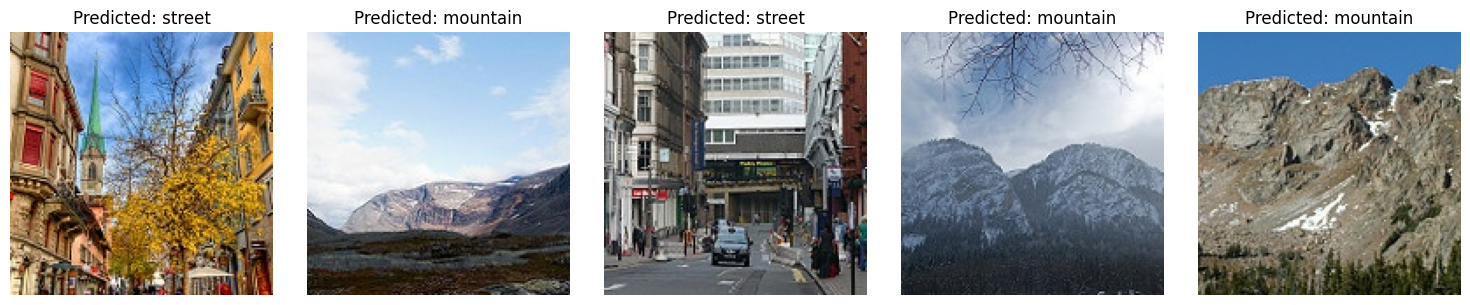

In [27]:
model_tl = tf.keras.models.load_model('model_tl.keras')
graficar_prediccion_modelo(model_tl)